# Práctica de reconstrucción.  Parte I. Calibración de cámaras

Visión Computacional <br>
Practica 2. 16 de octubre de 2019

Este enunciado está en el archivo "PracticaCalib.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, que está implementado en OpenCV.
* Hacer uso de los resultados de la calibración en un sistema simple de realidad aumentada que proyecte un modelo 3D sintético sobre imágenes reales. Esta parte es opcional.
* Calibrar un par de cámaras y deducir información sobre la posición relativa de las mismas.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* El enunciado de esta práctica.
* Dos secuencias de imágenes tomadas con un par de cámaras (izquierda y derecha) en los directorios ``left`` y ``right``.
* Tres modelos tridimensionales: la tetera de Utah (teapot), el conejo de Stanford (bunny) y un cubo (cube).   
  La carga de un modelo en Python se realiza como si fuera un módulo. Por ejemplo: ``from models import bunny``.
El módulo cargado contiene dos variables:
  - ``bunny.vertices`` es una matriz $4 × N_v$ con las coordenadas homogéneas de los $N_v$ vértices del modelo (en este caso, el conejo de Stanford). Cada columna son las coordenadas de un vértice.
  - bunny.edges es una matriz 2×N e con los N e arcos del modelo. Cada columna contiene los índices de los dos vértices que une un arco.

## Condiciones

* La fecha límite de entrega será el martes 29 de octubre a las 23:55.
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``left``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 30 mm en las direcciones X e Y.

In [1]:
# uncomment to show results in a window
# %matplotlib tk
import cv2
import glob
import copy
import numpy as np
import scipy.misc as scpm
import matplotlib.pyplot as ppl

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una lista de matrices de NumPy con las imágenes leídas.

In [2]:
def load_images(filenames):
    # return [scpm.imread(filename) for filename in filenames]
    return [ppl.imread(filename) for filename in filenames]

Usa ``load_images`` para cargar todas las imágenes del directorio ``left`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [3]:
import os
filenames = sorted(glob.glob('./left/*'))
left_images = load_images(filenames)

La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (8, 6) (*columnas x filas*). Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.


In [4]:
corners = [cv2.findChessboardCorners(image, (8, 6)) for image in left_images]

In [5]:
# This section is OPTIONAL
# cornerSubPix is destructive. so we copy standard corners and use the new list to refine
corners2 = copy.deepcopy(corners)

# Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
# termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
for i in range(len(left_images)):
    if corners2[i][0]:
        gray = cv2.cvtColor(left_images[i], cv2.COLOR_RGB2GRAY)
        cv2.cornerSubPix(gray, corners2[i][1], (8, 6), (-1, 1), criteria)
cornersRefined = corners2

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [6]:
imgs2 = copy.deepcopy(left_images)
imgs3 = copy.deepcopy(left_images)

for i in range(len(imgs2)):
    cv2.drawChessboardCorners(imgs2[i], (8, 6), corners[i][1], corners[i][0])
    cv2.drawChessboardCorners(imgs3[i], (8, 6), cornersRefined[i][1], cornersRefined[i][0])

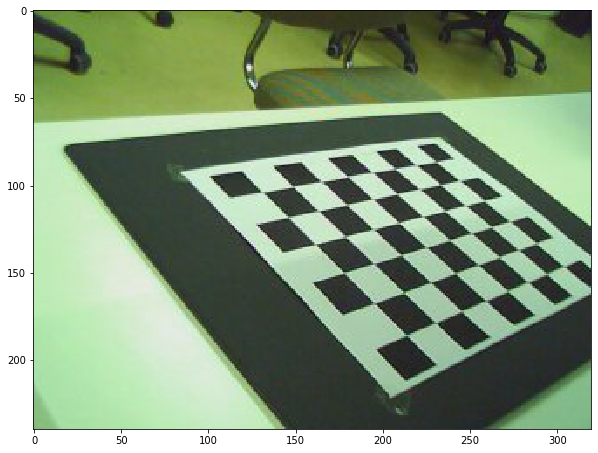

In [7]:
fig, ax = ppl.subplots(figsize=(10, 10))
ax.imshow(imgs2[0])
ppl.show()

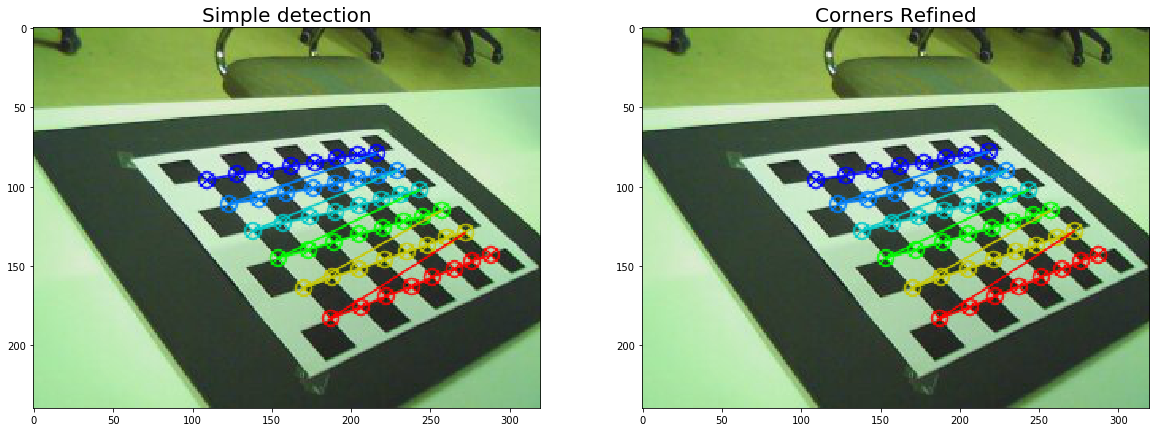

In [8]:
fig, ax = ppl.subplots(1, 2, figsize=(20, 20))

ax[0].set_title('Simple detection', size = 20)
ax[0].imshow(imgs2[1])

ax[1].set_title('Corners Refined', size = 20)
ax[1].imshow(imgs3[1])
ppl.show()

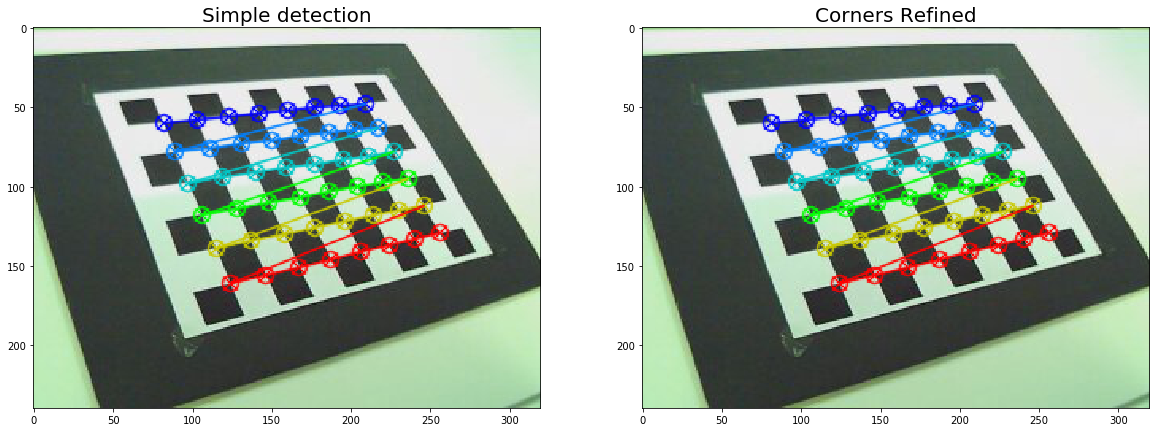

In [9]:
fig, ax = ppl.subplots(1, 2, figsize=(20, 20))

ax[0].set_title('Simple detection', size = 20)
ax[0].imshow(imgs2[10])

ax[1].set_title('Corners Refined', size = 20)
ax[1].imshow(imgs3[10])
ppl.show()

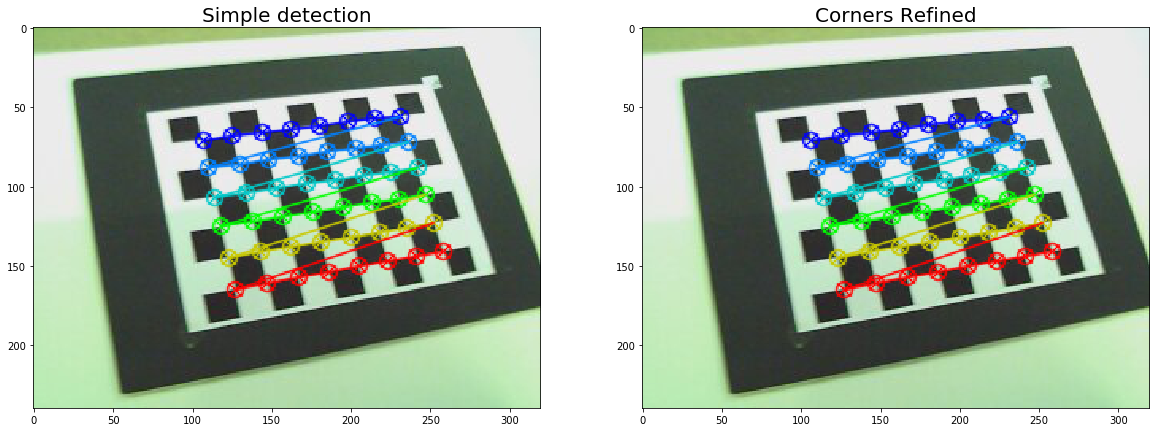

In [10]:
fig, ax = ppl.subplots(1, 2, figsize=(20, 20))

ax[0].set_title('Simple detection', size = 20)
ax[0].imshow(imgs2[18])

ax[1].set_title('Corners Refined', size = 20)
ax[1].imshow(imgs3[18])
ppl.show()

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$, resp. (*columna, fila, 0*),  de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos (*columnas, filas*) de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (8, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 30mm.

In [11]:
def get_chessboard_points(chessboard_shape, dx, dy): 
    col = chessboard_shape[0]
    row = chessboard_shape[1]
    points = np.zeros((col * row, 3))
    
    for i in range(row):
        for j in range(col):
            points[(i*col + j), :2] = (dx * i, dy * j)
            
    return points.astype(np.float32)

cb_points = get_chessboard_points((8, 6), 30, 30)
#print(cb_points)

**Ejercicio 4.** Calibra la cámara izquierda usando la lista de resultados de ``cv2.findChessboardCorners``
y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior.

In [12]:
# Extract the list of valid images with all corners
valid_corners = [corner[1] for corner in cornersRefined if corner[0]]
num_valid_images = len(valid_corners)

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points = np.repeat(np.expand_dims(cb_points, axis=0), num_valid_images, axis=0)
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points = np.array(valid_corners).reshape(len(valid_corners), -1, 2)
# Calibrate for square pixels corners standard
imageSize = left_images[0].shape[:2]
#cameraMatrix = cv2.initCameraMatrix2D(object_points, image_points, imageSize)

rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, imageSize, None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n",intrinsics)
print("Corners standerd dist_coefs:", dist_coeffs)
print("rms:", rms)

Corners standard intrinsics:
 [[424.94696467   0.         152.12607594]
 [  0.         424.94696467 126.15562   ]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs: [[-3.17885934e-02 -2.16523492e+00  4.69845938e-03 -6.17837295e-03
   1.13863805e+01]]
rms: 0.12343023278290126


###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 5.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (10,10) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagonal que abarca dicha región. Justifica esta solución.

In [13]:
import math

fx = intrinsics[0, 0]
fy = intrinsics[1, 1]

print('Focal: ', fx)

w = 50 + 10
h = 50 + 10

fovx = math.degrees(2 * math.atan(w / (2 * fx)))
fovy = math.degrees(2 * math.atan(h / (2 * fy)))
fovd = math.degrees(2 * math.atan(math.sqrt(w**2 + h**2) / (2 * fx)))

print('FovX: {}º   FovY: {}º'.format(fovx, fovy))
print('Ángulo de visión diagonal: {}º'.format(fovd))

Focal:  424.94696466613414
FovX: 8.076425757528016º   FovY: 8.076425757528016º
Ángulo de visión diagonal: 11.402953281839936º


Para realizar el calculo del área de visión usamos la distancia focal cuya longitud es igual a la distancia de la cámara al centro del plano. Usando la función arcotangente podemos obtener los ángulos de las áreas de visión usando como parámetro la distancia desde el centro del rectángulo a sus lados entre la distancia al centro del rectángulo. Como este calculo nos devuelve la mitad del ángulo, multiplicamos por 2 el resultado.
Debido a que la focal tiene una gran magnitud, la operación nos devuelve un ángulo de visión muy cerrado, solo estamos captando el campo de visión de un área pequeña de la imagen. Sería similar al ángulo de visión obtenido al realizar un zoom con la cámara un zoom con la cámara.

## 2. Realidad aumentada

El término *realidad aumentada* hace referencia al conjunto de técnicas que permiten representar información sintética no existente en el mundo real sobre imágenes reales. En nuestro caso, la información
sintética son modelos tridimensionales. Los siguientes ejercicios proponen una serie de pasos para implementar un
pequeño sistema de realidad aumentada, para lo cual serán necesarios los parámetros obtenidos durante la calibración.

**Ejercicio 6.** Implementa la función``m = proj(K, T, verts)`` que, dada la matriz de intrínsecos K (dimensión 3x3), extrínsecos T (dimensión 3 x 4) y una matriz de vértices expresados en coordenadas homogéneas ``verts``, calcule la proyección de los vértices 3D a puntos 2D de la imagen. Las coordenadas 2D resultantes deben ser homogéneas.
Es decir, este ejercicio consiste en implementar la ecuación de proyección vista en clase.

In [14]:
def proj(K, T, verts):
    return np.array( [K @ T @ vert for vert in verts.T] ).T

**Ejercicio 7.** Implementa una función ``plothom(points)`` que dibuje un conjunto de puntos 2D de entrada expresados en coordenadas homogéneas.

In [15]:
def plothom(points):
    ppl.plot(points[0] / points[2], points[1] / points[2], '.')

**Ejercicio 8.** Usa las funciones implementadas en los ejercicios anteriores para proyectar un modelo sobre las imágenes de la secuencia. Para ello, modifica la función ``play_ar``, que se distribuye con la práctica, completando las partes marcadas con TODO:

1. Proyecta los vértices del modelo con ``proj`` usando los intrínsecos y los extrínsecos de la imagen que corresponda.
2. Dibuja los vértices proyectados o los arcos correspondientes con ``plothom``.

Prueba la función ``play_ar`` una vez terminada.

In [16]:
def play_ar(intrinsics, rvecs, tvecs, imgs, vertices):
    
    fig = ppl.gcf()
    
    for rv,tv,img in zip(rvecs, tvecs, imgs):
        fig.clf()
        # ppl.figure()
        
        # Create rotation matrix from rotation vector rv, use cv2.Rodrigues()
        rm, _ =  cv2.Rodrigues(rv)
        # Create 3 x 4 extrinsics
        
        T = np.hstack((rm, tv))
        # Project the model with proj.
        v2d = proj(intrinsics, T, vertices)

        
        # Plot the image.
        ppl.imshow(img)
        
        # TODO: Draw the model with plothom
        plothom(v2d)
        
        # ppl.draw()
        ppl.show()
        ppl.pause(0.3)

In [17]:
# read bunny model
from models import bunny

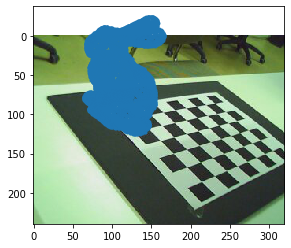

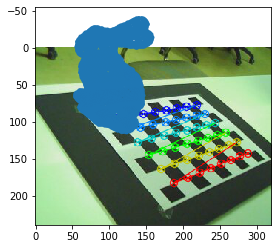

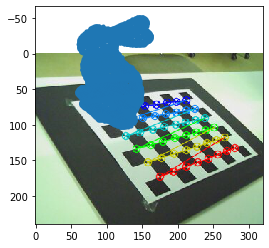

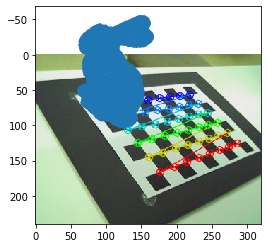

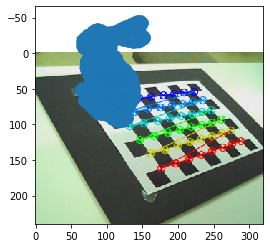

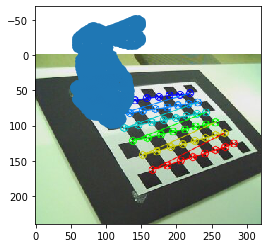

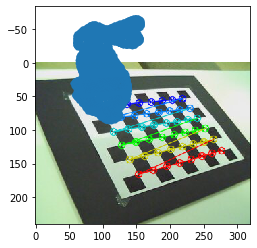

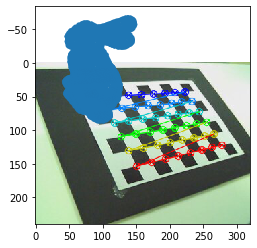

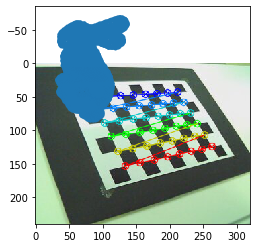

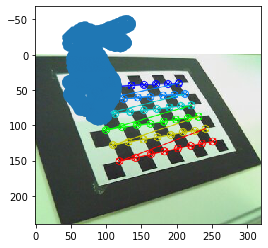

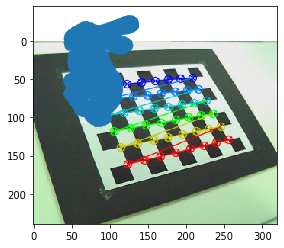

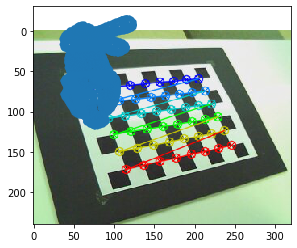

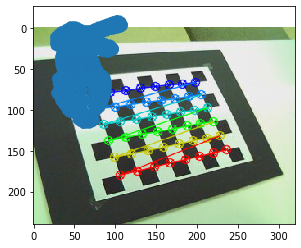

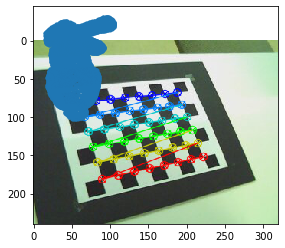

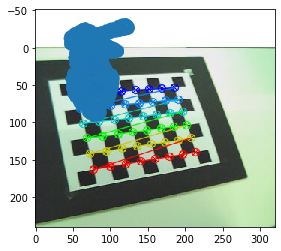

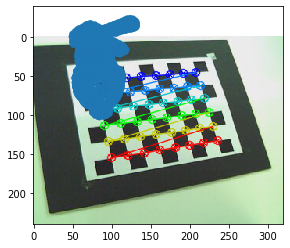

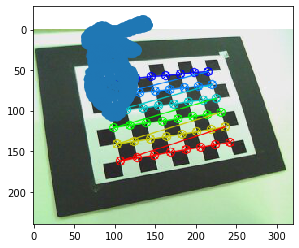

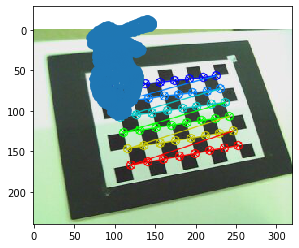

In [18]:
play_ar(intrinsics, rvecs, tvecs, imgs3, bunny.vertices)

**Ejercicio 9.** Transforma el modelo anterior para que se represente en
el centro de la plantilla de calibración y rotado 90 grados sobre el eje vertical del modelo. 
Ejecuta la función ``play_ar``con el nuevo modelo.

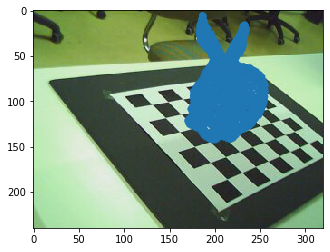

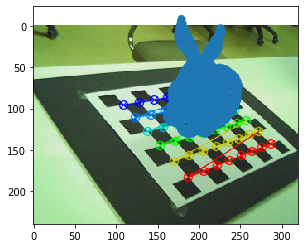

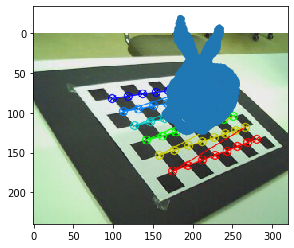

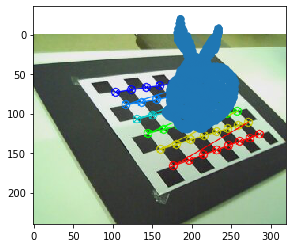

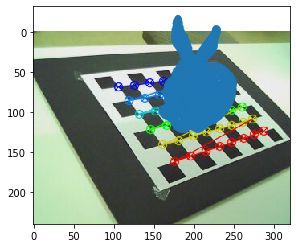

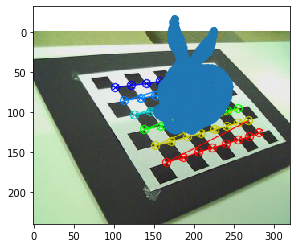

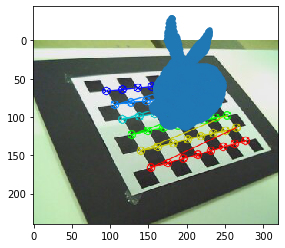

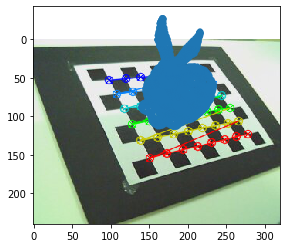

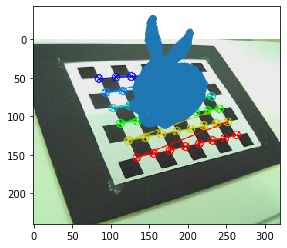

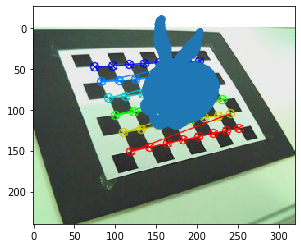

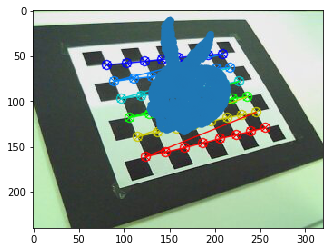

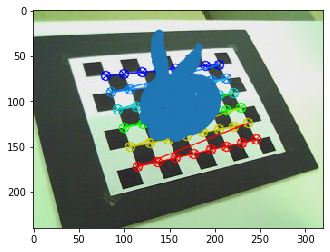

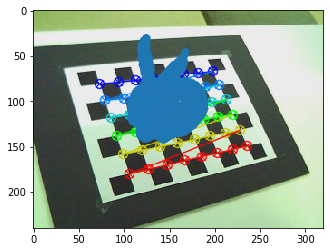

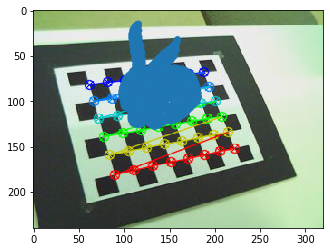

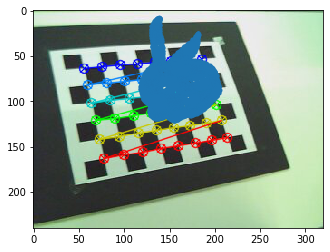

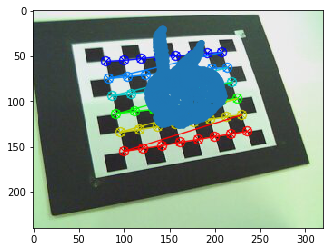

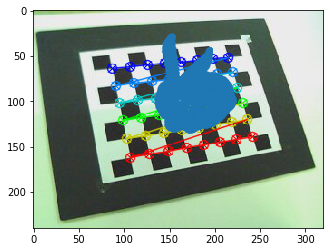

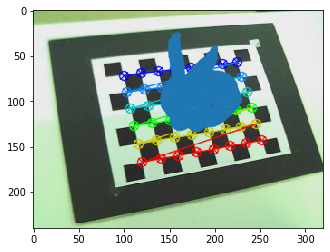

In [19]:
rot_mat, _ = cv2.Rodrigues((0, 0, np.pi / 2))
rot_mat = np.array(rot_mat)
cb_mid = np.array(object_points.mean(axis=0).mean(axis=0)).reshape((3, 1))
bunny_mid = np.array(bunny.vertices).mean(axis=1)

bunny_mid[2] = 0
translation = cb_mid + bunny_mid[0:3].reshape((3, 1))

transform = np.hstack((rot_mat, translation))
transform = np.vstack((transform, (0,0,0,1)))

new_vertices = transform @ bunny.vertices

play_ar(intrinsics, rvecs, tvecs, imgs3, new_vertices)

## 3. Par de cámaras

**Ejercicio 10.** Siguiendo el procedimiento de la primera parte
de la práctica, calibra la cámara derecha usando la secuencia
de imágenes del directorio ``right``.

In [20]:
filenames = sorted(glob.glob('./right/*'))
right_images = load_images(filenames)

corners_r = [cv2.findChessboardCorners(image, (8, 6)) for image in right_images]

# Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
# termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
for i in range(len(right_images)):
    if corners_r[i][0]:
        gray = cv2.cvtColor(right_images[i], cv2.COLOR_RGB2GRAY)
        cv2.cornerSubPix(gray, corners_r[i][1], (8, 6), (-1, 1), criteria)
cornersRefined_r = corners_r

imgs2_r = copy.deepcopy(right_images)

for i in range(len(imgs2_r)):
    cv2.drawChessboardCorners(imgs2_r[i], (8, 6), cornersRefined_r[i][1], cornersRefined_r[i][0])

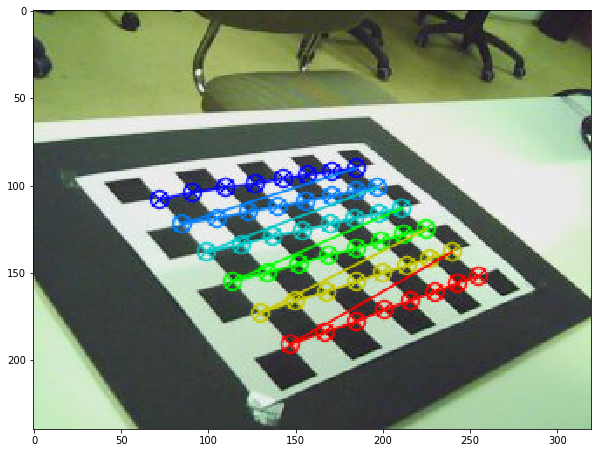

In [21]:
fig, ax = ppl.subplots(figsize=(10, 10))
ax.imshow(imgs2_r[0])
ppl.show()

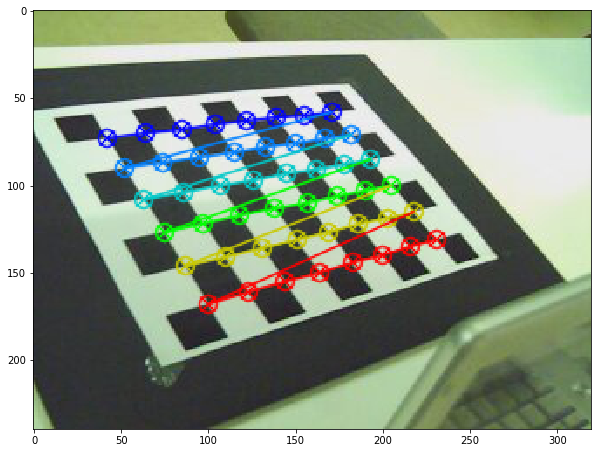

In [22]:
fig, ax = ppl.subplots(figsize=(10, 10))
ax.imshow(imgs2_r[5])
ppl.show()

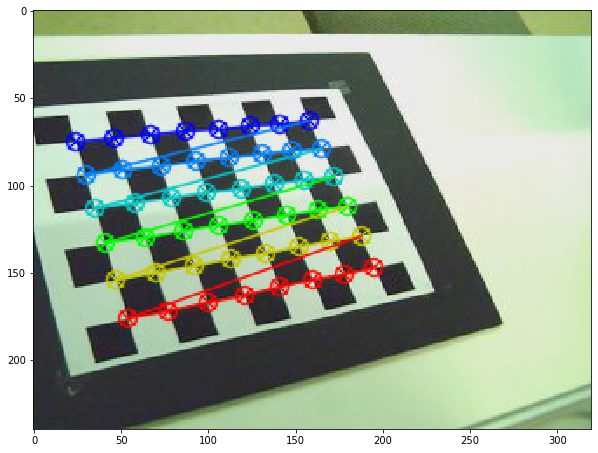

In [23]:
fig, ax = ppl.subplots(figsize=(10, 10))
ax.imshow(imgs2_r[11])
ppl.show()

In [24]:
# Extract the list of valid images with all corners
valid_corners_r = [corner[1] for corner in cornersRefined_r if corner[0]]
num_valid_images_r = len(valid_corners_r)

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points_r = np.repeat(np.expand_dims(cb_points, axis=0), num_valid_images_r, axis=0)
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points_r = np.array(valid_corners_r).reshape(len(valid_corners_r), -1, 2)
# Calibrate for square pixels corners standard
imageSize_r = right_images[0].shape[:2]
#cameraMatrix = cv2.initCameraMatrix2D(object_points, image_points, imageSize)

rms_r, intrinsics_r, dist_coeffs_r, rvecs_r, tvecs_r = cv2.calibrateCamera(object_points_r, image_points_r, imageSize_r, None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n",intrinsics_r)
print("Corners standerd dist_coefs:", dist_coeffs_r)
print("rms standard:", rms_r)

Corners standard intrinsics:
 [[431.94484495   0.         145.77848718]
 [  0.         431.94484495 135.72119658]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs: [[-0.12098547 -0.28675367  0.00685034 -0.00562149  2.2296959 ]]
rms standard: 0.10324794714365641


**Ejercicio 11.** ¿Cuál es la distancia, en milímetros, entre las dos cámaras?

Sugerencia: Utiliza los extrínsecos del primer par de imágenes el que simultáneamente se vean todos los puntos de la plantilla.


In [25]:
image_number = 0
# Right rotation matrix 
rot_mat_r, _ = cv2.Rodrigues(rvecs_r[image_number])
# Right camera position
# In rotation matrix the transpose matrix is the same as the inverse matrix
cameraPosition_r = -np.matrix(rot_mat_r).T * np.matrix(tvecs_r[image_number])

# Left rotation matrix 
rot_mat_l, _ = cv2.Rodrigues(rvecs[image_number])
# Left rotation matrix 
cameraPosition_l = -np.matrix(rot_mat_l).T * np.matrix(tvecs[image_number])

# Calculates the euclidean distance between the two images
distance = math.sqrt((cameraPosition_r[0] - cameraPosition_l[0])**2 + (cameraPosition_r[1] - cameraPosition_l[1])**2 + (cameraPosition_r[2] - cameraPosition_l[2])**2)
print(distance)

36.561648137868104
